Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 04-January-2026

In [85]:
# Import libraries 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import itertools
import networkx as nx
import random
import operator  
import seaborn as sns
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from collections import Counter
from sklearn.neighbors import KernelDensity

In [7]:
# Settings
data_dir = r'../data/'
syn_thresh = 5
nt_type_score_thresh = 0.62
nt_inhibitory_effect = ['GABA','GLUT']
shuffle = False # True
n_iterations = 1 # 10000
source_neurons = 'RRN_BPN' # 'RRN' or 'RRN_BPN'

In [61]:
# Load connectivity 
df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections.csv')
df_connectivity = df_connectivity.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")
    
# Load neuron classifications 
df_class = pd.read_csv(data_dir + 'flywire_v783_classifications.csv')

# Load neurotransmitter information 
df_nt = pd.read_csv(data_dir + 'flywire_v783_neurotransmitters.csv') 

# Load neurons of interest
df_neurons_of_interest = pd.read_csv(data_dir + 'neurons_of_interest.csv')

In [15]:
# Set source neurons
dict_nodes = {}
if source_neurons == 'RRN':
    dict_nodes['source_1'] = [df_neurons_of_interest.connectome_id[df_neurons_of_interest.community_name=='RRN'].tolist()[0]]
    dict_nodes['source_2'] = [df_neurons_of_interest.connectome_id[df_neurons_of_interest.community_name=='RRN'].tolist()[1]] 
elif source_neurons == 'RRN_BPN':
    dict_nodes['source_1'] = df_neurons_of_interest.connectome_id[df_neurons_of_interest.community_name=='RRN'].tolist() 
    dict_nodes['source_2'] = df_neurons_of_interest.connectome_id[df_neurons_of_interest.community_name.str.contains('BPN')].tolist()
    
source_nodes = list(itertools.chain(*list(dict_nodes.values())))

In [16]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [17]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]

In [18]:
# Update source nodes (applying a synapse threshold can remove source IDs from the connectivity dataframe)
source_nodes = [node for node in source_nodes if node in df_connectivity.pre_root_id.unique().tolist()]

In [19]:
# Build network graph
net = nx.DiGraph() 

# Get all nodes
nodes = pd.unique(df_connectivity[['pre_root_id', 'post_root_id']].values.ravel('K')) 

# Add nodes
net.add_nodes_from(nodes)

# Add edges
for index, row in tqdm(df_connectivity.iterrows(), total=len(df_connectivity)): 
    net.add_edge(df_connectivity["pre_root_id"][index], 
                 df_connectivity["post_root_id"][index], 
                 weight=int(df_connectivity.syn_count[index]))  
del nodes

100%|█████████████████████████████████████████████████████████████████████| 3732460/3732460 [01:46<00:00, 35036.04it/s]


In [20]:
# Get potential target IDs 
potential_target_nodes = df_class.root_id[df_class.super_class=='descending'].tolist()

# Include only target IDs that are in the synapse-thresholded dataframe
post_root_ids = df_connectivity.post_root_id.unique().tolist()
potential_target_nodes = [node for node in potential_target_nodes if node in post_root_ids]
del post_root_ids

In [21]:
# Find paths from source nodes to target nodes
path_length = 2 # Number of hops
intermediate_nodes = []
target_nodes = []

for source_node in source_nodes:
    for potential_target_node in potential_target_nodes: 
        if nx.has_path(net, source_node, potential_target_node):
            for path in nx.all_simple_paths(net, source_node, potential_target_node, cutoff=path_length):
                if len(path)==2:
                    target_nodes.append(path[-1])
                if len(path)==3:
                    # Exclude connections via source and target nodes
                    if (path[1] not in potential_target_nodes) and (path[1] not in source_nodes): 
                        intermediate_nodes.append(path[1])
                        target_nodes.append(path[-1])
                
intermediate_nodes = list(np.unique(intermediate_nodes)) 
target_nodes = list(np.unique(target_nodes))

In [22]:
# Confirm that none of the source nodes is an intermediate node
for i in source_nodes:
    if i in intermediate_nodes:
        print(i)

In [23]:
# Generate trimmed connectivity dataframe
# Remove 2-hop connections through source or target neurons
df_connectivity_trimmed = pd.DataFrame()
df_connectivity_trimmed = pd.concat([df_connectivity_trimmed,
                                     df_connectivity[
                                         ((df_connectivity['pre_root_id'].isin(source_nodes)) & 
                                          (df_connectivity['post_root_id'].isin(intermediate_nodes + target_nodes)))]
                                    ])
df_connectivity_trimmed = pd.concat([df_connectivity_trimmed, 
                                     df_connectivity[
                                         ((df_connectivity['pre_root_id'].isin(intermediate_nodes)) &
                                          (df_connectivity['post_root_id'].isin(target_nodes)))]       
                                    ])
df_connectivity_trimmed

,pre_root_id,post_root_id,syn_count
14448527,720575940630915791,720575940620802836,76
18268177,720575940639781027,720575940604458668,73
14098851,720575940630460975,720575940620802836,61
18268287,720575940639781027,720575940618380052,57
16020149,720575940633362145,720575940611246810,56
...,...,...,...
1973603,720575940612337331,720575940628030440,5
1973648,720575940612337331,720575940629155227,5
1973684,720575940612337331,720575940630346860,5
1973879,720575940612337331,720575940647586948,5


In [24]:
# Get all nodes
nodes = source_nodes + intermediate_nodes + target_nodes

In [25]:
# Generate dataframe with information about each node
index, root_id, nt_type, nt_type_score, super_class, sub_class = [], [], [], [], [], []

node_keys = list(dict_nodes.keys())

for index_node, node in enumerate(nodes):       
    if node in source_nodes:
        super_class_node = "source"
    elif node in intermediate_nodes:
        super_class_node = "intermediate"
    elif node in target_nodes:
        super_class_node = "target"
    else:
        print('Error')
    
    if node in source_nodes: 
        for key in node_keys:
            if node in dict_nodes[key]:
                sub_class_node = key
    else:
        sub_class_node = ""

    nt_type_node = df_nt.nt_type[df_nt.root_id==node].item()
    nt_type_score_node = df_nt.nt_type_score[df_nt.root_id==node].item()
    if pd.isnull(nt_type_node):
        nt_type_node = "unknown"
    elif super_class_node == "intermediate" and nt_type_score_node < nt_type_score_thresh: 
        nt_type_node = "unknown"
        
    index.append(index_node)
    root_id.append(node)
    nt_type.append(nt_type_node)
    nt_type_score.append(nt_type_score_node)
    super_class.append(super_class_node)
    sub_class.append(sub_class_node)
        
        
df_indices = pd.DataFrame()
df_indices["matrix_index"] = index # .index refers to the dataframe index
df_indices["root_id"] = root_id
df_indices["nt_type"] = nt_type
df_indices["nt_type_score"] = nt_type_score
df_indices["super_class"] = super_class
df_indices["sub_class"] = sub_class

In [26]:
# Generate connectivity matrix with output fractions
# Note: This matrix is not an all-to-all adjacency matrix; it only contains 2-hop feedforward connections from source nodes. 

conn_mat_fractional_outputs = np.zeros((len(nodes),len(nodes)))
for index_pre_node, node in enumerate(nodes):
    # Get total number of output synapses of pre node 
    n_outputs = df_connectivity.syn_count[(df_connectivity['pre_root_id'] == node)].sum()
    
    # Get postsynaptic connectivity of pre node in trimmed dataframe
    df = df_connectivity_trimmed[(df_connectivity_trimmed['pre_root_id'] == node)]
    
    for row_index, row in df.iterrows():
        syn_count = row["syn_count"]
        post_node = row["post_root_id"]
        index_post_node = nodes.index(post_node)
        
        conn_mat_fractional_outputs[index_pre_node,index_post_node] += syn_count/n_outputs    

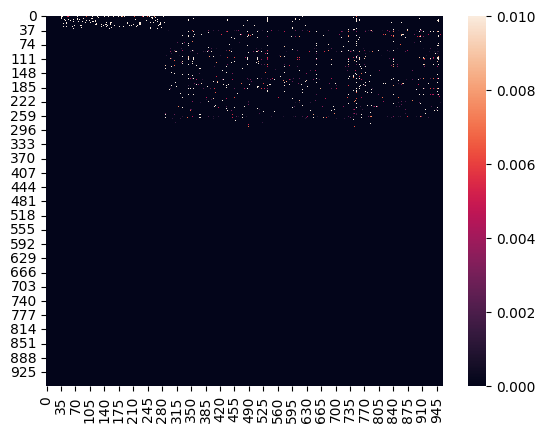

In [27]:
# Plot connectivity matrix 
sns.heatmap(conn_mat_fractional_outputs, vmax=0.01);

In [28]:
# Compute output from source nodes onto intermediate and target nodes
# Optional: Shuffle output connections of each source node
shared_source_1_output = []
shared_source_2_output = []

for iteration in tqdm(range(n_iterations)):
    
    # Shuffle output connections of each source node
    conn_mat_shuffled = conn_mat_fractional_outputs.copy()

    if shuffle:
        source_indices = df_indices.index[df_indices["super_class"]=="source"].tolist()
        for index in source_indices:
            # Shuffle output onto intermediate and target nodes
            post_index = list(range(len(source_nodes), len(nodes)))
            random.shuffle(post_index)

            conn_mat_shuffled[index, len(source_nodes):] = conn_mat_shuffled[index, post_index] 
        
        
    # Classify intermediate nodes 
    intermediate_indices = df_indices.index[df_indices["super_class"]=="intermediate"].tolist()
    
    source_1_indices = df_indices.index[df_indices["sub_class"]=="source_1"].tolist()
    source_2_indices = df_indices.index[df_indices["sub_class"]=="source_2"].tolist()

    for index in intermediate_indices:        
        any_source_1_input = any(conn_mat_shuffled[source_1_indices, index]>0)
        any_source_2_input = any(conn_mat_shuffled[source_2_indices, index]>0)

        if any_source_1_input and any_source_2_input:
            sub_class = "intermediate_12"
        elif any_source_1_input and not any_source_2_input: 
            sub_class = "intermediate_1"
        elif any_source_2_input and not any_source_1_input: 
            sub_class = "intermediate_2"
        else:
            sub_class = "intermediate_other"

        df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = sub_class

     # Note: When connections are shuffled, some intermediate nodes are no longer connected to source nodes
     #if "intermediate_other" in df_indices.sub_class.unique().tolist():
     #    print("Some intermediate neurons not connected to source neurons")
    
        
    # Classify target nodes 
    target_indices = df_indices.index[df_indices["super_class"]=="target"].tolist()
    
    source_1_indices = df_indices.index[(df_indices["sub_class"]=="source_1") |
                                        (df_indices["sub_class"]=="intermediate_1")].tolist()
    source_2_indices = df_indices.index[(df_indices["sub_class"]=="source_2") |
                                        (df_indices["sub_class"]=="intermediate_2")].tolist()
    source_12_indices = df_indices.index[df_indices["sub_class"]=="intermediate_12"].tolist()

    for index in target_indices:
        any_source_1_input = any(conn_mat_shuffled[source_1_indices, index]>0)
        any_source_2_input = any(conn_mat_shuffled[source_2_indices, index]>0)
        any_source_12_indices = any(conn_mat_shuffled[source_12_indices, index]>0)

        if (any_source_1_input and any_source_2_input) or any_source_12_indices:
            sub_class = "target_12"
        else: 
            sub_class = "target_other"

        df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = sub_class

    
    # Further classify intermediate nodes 
    target_12_indices = df_indices.index[df_indices["sub_class"]=="target_12"].tolist()

    intermediate_1_indices = df_indices.index[df_indices["sub_class"]=="intermediate_1"].tolist()
    intermediate_2_indices = df_indices.index[df_indices["sub_class"]=="intermediate_2"].tolist()    

    for index in intermediate_1_indices:
        any_shared_output = any(conn_mat_shuffled[index, target_12_indices]>0)    
        if any_shared_output: 
             df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = "intermediate_1_shared"


    for index in intermediate_2_indices:
        any_shared_output = any(conn_mat_shuffled[index, target_12_indices]>0)   
        if any_shared_output: 
             df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = "intermediate_2_shared"
  
                
    # Further classify target nodes 
    target_other_indices = df_indices.index[df_indices["sub_class"]=="target_other"].tolist()

    # Note: After previous classification, intermediate_1 and intermediate_2 do not project to target_12 
    source_1_indices = df_indices.index[(df_indices["sub_class"]=="source_1") |
                                        (df_indices["sub_class"]=="intermediate_1") | 
                                        (df_indices["sub_class"]=="intermediate_1_shared")].tolist()
    source_2_indices = df_indices.index[(df_indices["sub_class"]=="source_2") |
                                        (df_indices["sub_class"]=="intermediate_2") |
                                        (df_indices["sub_class"]=="intermediate_2_shared")].tolist()

    for index in target_other_indices:
        any_source_1_input = any(conn_mat_shuffled[source_1_indices, index]>0)
        any_source_2_input = any(conn_mat_shuffled[source_2_indices, index]>0)

        if any_source_1_input and not any_source_2_input:
            sub_class = "target_1"
        elif any_source_2_input and not any_source_1_input:
            sub_class = "target_2"
        else:
            sub_class = "target_other"

        df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = sub_class
   
    
    # Get summed relative output of source_1 onto shared pathways
    source_indices = df_indices.index[df_indices["sub_class"]=="source_1"].tolist()
    shared_indices = df_indices.index[(df_indices["sub_class"]=="intermediate_12") |
                                      (df_indices["sub_class"]=="intermediate_1_shared") | 
                                      (df_indices["sub_class"]=="target_12")].tolist()

    shared_source_1_output.append(np.mean(np.sum(conn_mat_shuffled[source_indices,:][:,shared_indices],axis=1)))
    
    # Get summed relative output of source_2 onto shared pathways
    source_indices = df_indices.index[df_indices["sub_class"]=="source_2"].tolist()
    shared_indices = df_indices.index[(df_indices["sub_class"]=="intermediate_12") |
                                      (df_indices["sub_class"]=="intermediate_2_shared") | 
                                      (df_indices["sub_class"]=="target_12")].tolist()

    shared_source_2_output.append(np.mean(np.sum(conn_mat_shuffled[source_indices,:][:,shared_indices],axis=1)))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


In [29]:
# Display shared output from Source 1
print(shared_source_1_output)

[np.float64(0.9956331877729256)]


In [30]:
# Display shared output from Source 2
print(shared_source_2_output)

[np.float64(0.8744470053838791)]


In [31]:
# Plot distribution of shared output 
if shuffle:
    data_to_plot = shared_source_1_output
    binwidth = 0.01
    plt.hist(data_to_plot, bins=np.arange(0-binwidth/2, 1+binwidth/2+binwidth, binwidth), density=True)
    plt.plot([np.mean(data_to_plot),np.mean(data_to_plot)],[0,12])
    plt.plot([0.874,0.874],[0,12],'k')
    plt.xlim([0,1.2])
    print(np.mean(data_to_plot))
    # plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
    plt.show()

In [32]:
# Add group label for pooling nodes below 
group = []
if source_neurons == 'N':
    for index, row in df_indices.iterrows():
        super_class = df_indices.super_class[index]
        group.append(super_class)
else:
    for index, row in df_indices.iterrows():
        sub_class = df_indices.sub_class[index]
        group.append(sub_class)

df_indices["group"] = group 

In [33]:
# Generate all-to-all connectivity matrix for neuron groups (specified above) with merged fractional output
groups = df_indices.group.unique().tolist()
conn_mat_group_fractional_outputs = np.zeros((len(groups), len(groups)))

for group_index, group in enumerate(groups):
    pre_root_ids = df_indices.root_id[df_indices['group']==group].tolist()
    
    # Get total number of output synapses of pre root IDs from un-trimmed connectivity dataframe
    n_outputs = df_connectivity.syn_count[(df_connectivity['pre_root_id'].isin(pre_root_ids))].sum()
    
    # Get all post root IDs of pre root IDs 
    df = df_connectivity[(df_connectivity['pre_root_id'].isin(pre_root_ids)) 
                        & df_connectivity['post_root_id'].isin(nodes)]
        
    # Sum synapses for pre root IDs
    df = df.groupby(['post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

    # Loop over post root IDs
    for index, row in df.iterrows():
        post_root_id = df.post_root_id[index]
        rel_weight = df.syn_count[index] / n_outputs
        
        post_root_id_group = df_indices.group[df_indices["root_id"]==post_root_id].item()
        if post_root_id_group in groups:
            idx = groups.index(post_root_id_group)
            conn_mat_group_fractional_outputs[group_index,idx] += rel_weight

# Correct output fraction of descending neurons
correction_factor = 0.25 # Estimated based on BANC
if source_neurons == 'RRN':
    conn_mat_group_fractional_outputs[:][[2]] = conn_mat_group_fractional_outputs[[2]][:] * correction_factor
else:
    conn_mat_group_fractional_outputs[:][[6,7,8]] = conn_mat_group_fractional_outputs[[6,7,8]][:] * correction_factor

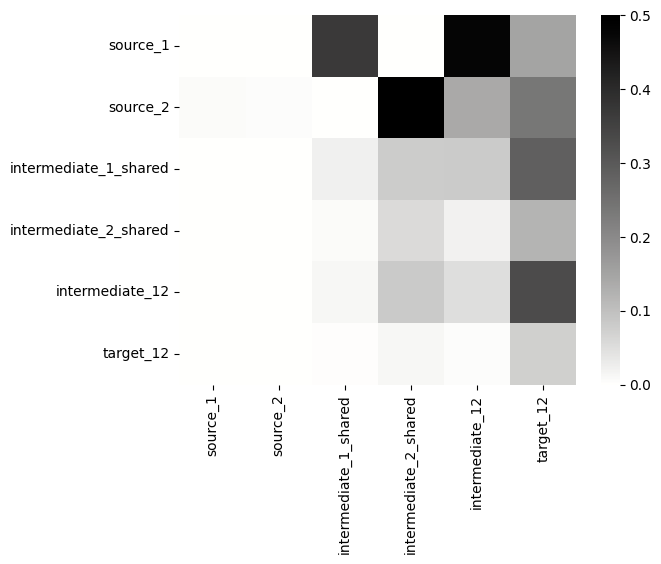

In [34]:
# Plot all-to-all connectivity matrix
cmap = cmocean.cm.gray_r
plot_index = [0,1,2,3,4,6]
groups = np.array(groups)
sns.heatmap(conn_mat_group_fractional_outputs[plot_index,:][:,plot_index], 
            xticklabels = groups[plot_index], 
            yticklabels = groups[plot_index],
            cmap = cmap)
#plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
plt.show()

In [35]:
# Display number of neurons per group 
groups = df_indices.group.unique().tolist()
for group in groups:
    n = len(df_indices[df_indices["group"]==group])
    print(group + ': ' + str(n))

source_1: 2
source_2: 32
intermediate_1_shared: 51
intermediate_2_shared: 157
intermediate_12: 30
intermediate_2: 16
target_12: 353
target_2: 306
target_1: 14


In [36]:
# Calculate output of one group of neurons onto another  
pre_index = groups.index("source_2") 
post_index = groups.index("intermediate_2_shared")
np.sum(conn_mat_group_fractional_outputs[pre_index,post_index]) 

np.float64(0.5005148005148005)

In [37]:
# Get synapse counts, super classes, and neurotransmitter types of intermediate neurons and sort
if source_neurons == 'RRN_BPN':

    # Set groups
    groups = ["intermediate_1_shared","intermediate_12","intermediate_2_shared"]
    
    # Set ranks for sorting
    class_rank = {}
    class_rank['descending'] = 0
    class_rank['central'] = 1
    class_rank['motor'] = 2
    class_rank['ascending'] = 3
    class_rank['sensory'] = 4
    class_rank['optic'] = 5
    class_rank['visual_projection'] = 6
    class_rank['visual_centrifugal'] = 7
    class_rank['endocrine'] = 8
    
    nt_rank = {}
    nt_rank['ACH'] = 0
    nt_rank['DA'] = 1
    nt_rank['OCT'] = 2
    nt_rank['SER'] = 3
    nt_rank['GABA'] = 4
    nt_rank['GLUT'] = 5
    
    n_syn_source_1, n_syn_source_2, group_ranks, class_ranks, nt_ranks, node_indices = [], [], [], [], [], []
    
    # Get root IDs of neurons in specific groups
    node_index = 0
    for index, group in enumerate(groups):
        root_ids = df_indices.root_id[df_indices["group"] == group].tolist()
        for root_id in root_ids:
            n_syn_source_1.append(df_connectivity_trimmed.syn_count[(df_connectivity_trimmed.pre_root_id.isin(dict_nodes['source_1'])) 
                         & (df_connectivity_trimmed.post_root_id == root_id)].sum())
            n_syn_source_2.append(df_connectivity_trimmed.syn_count[(df_connectivity_trimmed.pre_root_id.isin(dict_nodes['source_2'])) 
                         & (df_connectivity_trimmed.post_root_id == root_id)].sum())
    
            group_ranks.append(index)
            
            super_class = df_class.super_class[df_class.root_id == root_id].item()
            class_ranks.append(class_rank[super_class])
    
            if df_indices.nt_type_score[df_indices.root_id == root_id].item() < 0.62:
                nt_ranks.append(6)
            else:
                nt_type = df_indices.nt_type[df_indices.root_id == root_id].item()
                nt_ranks.append(nt_rank[nt_type])
    
            node_index += 1
            node_indices.append(node_index-1)
    
    # Create list of tuples with relevant sorting information
    sort_list = list(zip(group_ranks, class_ranks, n_syn_source_1, n_syn_source_2, nt_ranks, node_indices))
    
    # Sort list 
    sorted_list = sorted(sort_list, key=operator.itemgetter(3), reverse=True) # n_syn_source_2
    sorted_list = sorted(sorted_list, key=operator.itemgetter(2), reverse=True) # n_syn_source_1
    sorted_list = sorted(sorted_list, key=operator.itemgetter(1), reverse=False) # class_ranks
    sorted_list = sorted(sorted_list, key=operator.itemgetter(0), reverse=False) # group_ranks
    
    # Create connectivity matrix
    conn_mat = np.zeros((2,node_index))
    conn_mat[0] = n_syn_source_1
    conn_mat[1] = n_syn_source_2
    
    # Sort connectivity matrix
    index_sorted = [t[5] for t in sorted_list]
    conn_mat_sorted = conn_mat[:,index_sorted]
    
    group_ranks_sorted = [t[0] for t in sorted_list]
    class_ranks_sorted = [t[1] for t in sorted_list]
    nt_ranks_sorted = [t[4] for t in sorted_list]

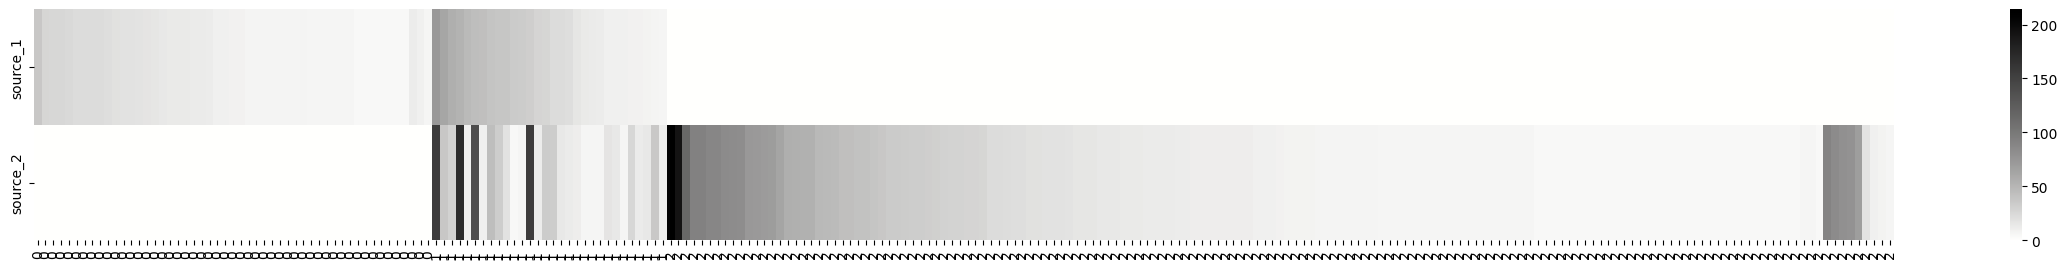

In [38]:
# Plot synapse counts of intermediate neurons
if source_neurons == 'RRN_BPN':
    fig = plt.figure(figsize=(30,3))
    cmap = cmocean.cm.gray_r
    
    sns.heatmap(conn_mat_sorted,
                cmap = cmap,
                yticklabels = ['source_1','source_2'],
                xticklabels = group_ranks_sorted)
    #plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
    plt.show()

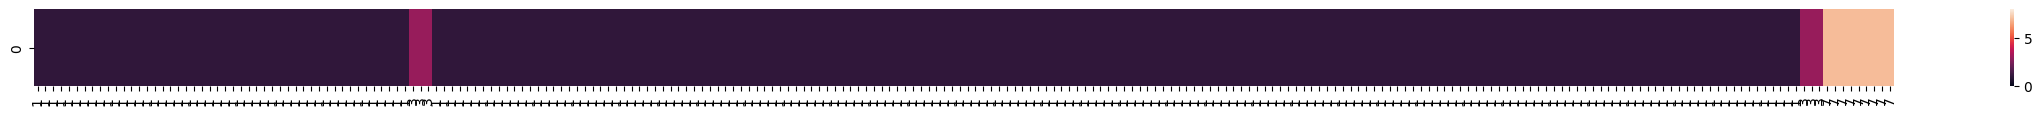

In [39]:
# Plot super classes of intermediate neurons
if source_neurons == 'RRN_BPN':
    super_class = np.zeros([1,len(class_ranks_sorted)])
    for index, _ in enumerate(class_ranks_sorted):
        super_class[:,index] = class_ranks_sorted[index]
    
    plt.figure(figsize=(30, 1))
    sns.heatmap(super_class,
               vmin=0, vmax=8, 
               xticklabels = class_ranks_sorted)
    #plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
    plt.show()

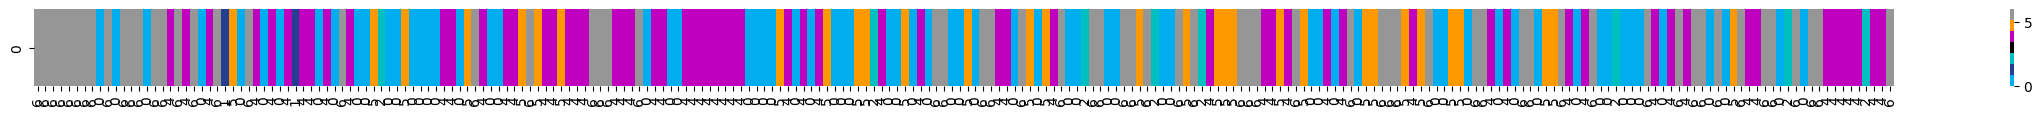

In [40]:
# Plot neurotransmitter type of intermediate neurons
if source_neurons == 'RRN_BPN':
    nt = np.zeros([1,len(nt_ranks_sorted)])
    for index, _ in enumerate(nt_ranks_sorted):
        nt[:,index] = nt_ranks_sorted[index]
    
    colors = np.array([[0,174,239], [36,62,144], [0,191,191], [0,0,0], [191,0,191], [255,153,0], [150, 150, 150]])/255
    cmap = ListedColormap(colors)
    
    plt.figure(figsize=(30, 1))
    sns.heatmap(nt, 
                cmap = cmap,
                xticklabels = nt_ranks_sorted)
    #plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
    plt.show()

In [41]:
def plot_list_profile(input_list, sort_list):

    # Get unique list elements
    keys = list(Counter(input_list).keys())
    values = list(Counter(input_list).values())
    values_sum = np.sum(values)
    values = values/values_sum
    
    # Sort list elements
    sort_list = [sort_list[index] for index, key in enumerate(sort_list) if key in input_list]
    sort_index = [keys.index(key) for key in sort_list]
    keys = [keys[index] for index in sort_index]
    values = [values[index] for index in sort_index]
    
    # Generate dictionary for plotting
    plot_dict = {}
    for index, key in enumerate(keys):
        plot_dict[key] = values[index]
        
    # Plot stacked bar graph 
    fig, ax = plt.subplots()
    width = 0.5   
    bottom = 0
    for key in plot_dict.keys():
        p = ax.bar(1, plot_dict[key], width, label=key, bottom=bottom)
        bottom += plot_dict[key]
    plt.xlim(0,2)
    ax.legend(loc="upper right")

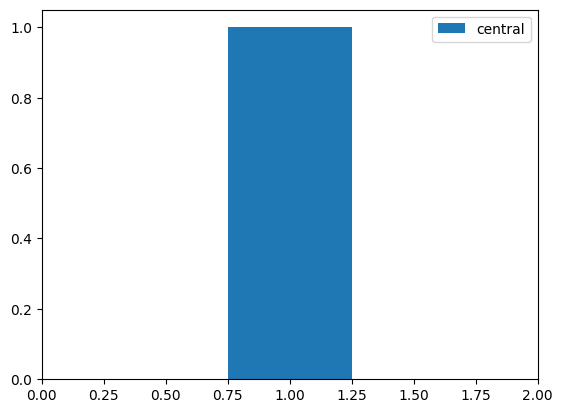

In [42]:
# Plot super class and neurotransmitter profile of specific group of neurons
group = "intermediate_12"

# Get root IDs of neurons in specific group
root_ids = df_indices.root_id[df_indices["group"]==group].tolist()

# Get super classes and neurotransmitters
super_class = []
nt_types = []
for root_id in root_ids:
    super_class.append(df_class.super_class[df_class.root_id==root_id].item())
    nt_types.append(df_indices.nt_type[df_indices.root_id==root_id].item())

# Plot super class profile
plot_list_profile(super_class, ['visual_centrifugal','ascending','central'])

# Plot neurotransmitter profile
#plot_list_profile(nt_types, ['unknown','DA','OCT','GLUT','GABA','ACH'])

In [43]:
# Generate connectivity matrix with input fractions
if source_neurons == 'RRN_BPN':
    conn_mat_fractional_inputs = np.zeros((len(nodes),len(nodes)))
    for index_post_node, node in enumerate(nodes):
        # Get total number of input synapses of node 
        n_inputs = df_connectivity.syn_count[(df_connectivity['post_root_id'] == node)].sum()
        
        # Get presynaptic connectivity of node in trimmed dataframe
        df = df_connectivity_trimmed[(df_connectivity_trimmed['post_root_id'] == node)]
        
        for row_index, row in df.iterrows():
            syn_count = row["syn_count"]
            pre_node = row["pre_root_id"]
            index_pre_node = nodes.index(pre_node)
            
            conn_mat_fractional_inputs[index_pre_node,index_post_node] += syn_count/n_inputs

In [44]:
# Trim connectivity matrix to shared pathways and add inhibitory effect
if source_neurons == 'RRN_BPN':
    # For RRN vs BPN, select only shared pathways
    sub_classes = ["source_1", 
                   "source_2", 
                   "intermediate_12", 
                   "intermediate_1_shared", 
                   "intermediate_2_shared", 
                   "target_12"]

    conn_mat_shared = conn_mat_fractional_inputs.copy()
    indices_to_keep = []
    
    for index in range(len(df_indices)):
        sub_class = df_indices.sub_class[index]
        nt_type = df_indices.nt_type[index]
        
        if sub_class in sub_classes:
            indices_to_keep.append(index)      
        
        # Set outputs of neurons with unknown neurotransmitter to zero. 
        # Note that only intermediate neurons with a prediction score smaller nt_score_thresh are set to 'unknown' above.
        if nt_type == 'unknown':
            conn_mat_shared[index,:] = conn_mat_shared[index,:]*0
        
        # Make inhibitory connections negative
        if nt_type in nt_inhibitory_effect:
            conn_mat_shared[index,:] = conn_mat_shared[index,:]*-1
        
    # Trim matrix 
    conn_mat_shared = conn_mat_shared[np.array(indices_to_keep),:][:,np.array(indices_to_keep)]

In [45]:
# Generate new version of df_indices for conn_mat_shared
if source_neurons == 'RRN_BPN':
    df_indices_shared = df_indices[df_indices["matrix_index"].isin(indices_to_keep)]
    df_indices_shared["matrix_index"] = indices_to_keep
    df_indices_shared = df_indices_shared.reset_index(drop=True)
    df_indices_shared

In [46]:
# Compute connectivity strength
if source_neurons == 'RRN_BPN':
    conn_mat_shared_one_hop = conn_mat_shared.copy() 
    conn_mat_shared_two_hops = np.matmul(conn_mat_shared_one_hop, conn_mat_shared_one_hop)
    conn_mat_shared_one_two_hops = conn_mat_shared_one_hop + conn_mat_shared_two_hops

In [47]:
def sort_nodes(conn_mat,source_indices,target_indices):
    
    conn_strength = conn_mat[source_indices[0],target_indices]
    for index, source_index in enumerate(source_indices):
        if index>0:
            conn_strength += conn_mat[source_index,target_indices]
    
    target_indices_sorted = (-conn_strength).argsort()  
    conn_strength_sorted = conn_strength[target_indices_sorted]
    
    return target_indices_sorted, conn_strength_sorted

In [48]:
# Build dataframe with target nodes ranked based on connectivity strength
if source_neurons == 'RRN_BPN':

    target_indices = df_indices_shared.index[df_indices_shared["sub_class"] == "target_12"].tolist()
    target_ids = df_indices_shared.root_id[df_indices_shared["sub_class"] == "target_12"].tolist()

    # Rank target nodes based on combined connectivity strength from source_1 and source_2
    source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_1","source_2"])].tolist()
    target_indices_sorted, conn_strength_sorted = sort_nodes(conn_mat_shared_one_two_hops, source_indices, target_indices)
    target_ids_sorted = [target_ids[index] for index in target_indices_sorted]
    
    # Rank target nodes based on connectivity strength from source_1
    source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_1"])].tolist()
    target_indices_sorted_source_1, conn_strength_sorted_source_1 = sort_nodes(conn_mat_shared_one_two_hops, source_indices, target_indices)
    
    # Rank target nodes based on connectivity strength from source_2
    source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_2"])].tolist()
    target_indices_sorted_source_2, conn_strength_sorted_source_2 = sort_nodes(conn_mat_shared_one_two_hops, source_indices, target_indices)
    
    
    # Build dataframe
    df_targets_ranked = pd.DataFrame()
    df_targets_ranked['root_id'] = target_ids_sorted
    
    df_targets_ranked['rank_source_12'] = np.linspace(1, len(target_ids_sorted), len(target_ids_sorted)).astype(int)
    df_targets_ranked['conn_strength_source_12'] = conn_strength_sorted
    
    map_index = [np.argwhere(target_indices_sorted_source_1 == index)[0][0] for index in target_indices_sorted]
    df_targets_ranked['rank_source_1'] = map_index
    df_targets_ranked['rank_source_1'] += 1
    df_targets_ranked['conn_strength_source_1'] = conn_strength_sorted_source_1[map_index] 
    
    map_index = [np.argwhere(target_indices_sorted_source_2 == index)[0][0] for index in target_indices_sorted]
    df_targets_ranked['rank_source_2'] = map_index
    df_targets_ranked['rank_source_2'] += 1
    df_targets_ranked['conn_strength_source_2'] = conn_strength_sorted_source_2[map_index]

In [49]:
# Add relative input from shared circuit neurons
if source_neurons == 'RRN_BPN':
    syn_count_shared_rel = []
    
    pre_ids = df_indices_shared.root_id[df_indices_shared.group.isin(['source_1','source_2','intermediate_12','intermediate_1_shared','intermediate_2_shared'])].tolist()
    target_ids = df_targets_ranked.root_id.tolist()
    for target_id in target_ids:
        syn_count_total = df_connectivity.syn_count[df_connectivity.post_root_id==target_id].sum().item()
        syn_count_shared = df_connectivity.syn_count[(df_connectivity.post_root_id==target_id) & (df_connectivity.pre_root_id.isin(pre_ids))].sum().item()
        syn_count_shared_rel.append(syn_count_shared/syn_count_total)
    
    df_targets_ranked['syn_count_shared_rel'] = syn_count_shared_rel

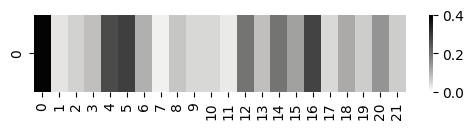

In [51]:
# Plot relative input from the shared circuit onto specific descending neurons
if source_neurons == 'RRN_BPN':
    
    cell_types = ["DNp52", "DNg101", "DNg102", "DNp64", "DNge050", "DNd05", "DNge048", "DNg45", "DNge082", "DNpe020", "DNg44", 
                  "DNge103", "DNpe053", "DNp13", "DNge053", "DNge150", "DNp68", "DNp66", "DNpe042", "DNp45", "DNg55", "DNge138"]

    # Loop over cell types
    syn_count_shared_rel = []
    for cell_type in cell_types:
        root_ids = df_neurons_of_interest.connectome_id[df_neurons_of_interest.cell_type == cell_type].tolist()
        syn_count_shared_rel.append(df_targets_ranked.syn_count_shared_rel[df_targets_ranked.root_id.isin(root_ids)].mean().tolist())

    # Plot
    cmap = cmocean.cm.gray_r
    plt.figure(figsize=(6, 1))

    sns.heatmap([syn_count_shared_rel],
                cmap = cmap, 
                vmin = 0, 
                vmax = 0.4)
    #plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
    plt.show()

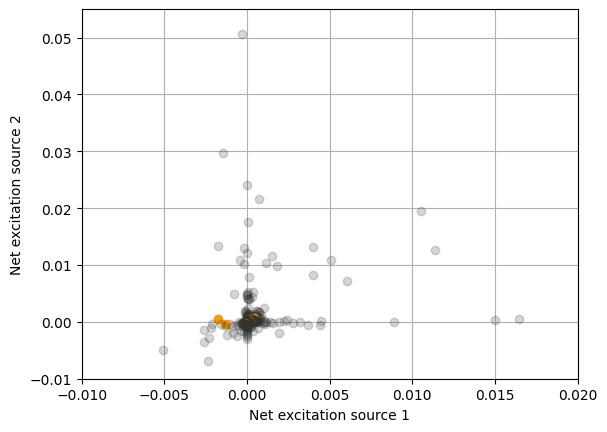

In [66]:
# Plot net excitation onto target nodes per source 
# Highlight descending neurons known to drive turning 
if source_neurons == 'RRN_BPN':
    
    target_ids = df_targets_ranked.root_id.tolist()
    ids_of_interest = df_neurons_of_interest.connectome_id.tolist()
    for index, target_id in enumerate(target_ids):
        color = [0.2,0.2,0.2,0.2]
        if target_id in ids_of_interest:
            name = df_neurons_of_interest.community_name[df_neurons_of_interest.connectome_id == target_id].item()       
            motor_program = df_neurons_of_interest.motor_program[df_neurons_of_interest.connectome_id == target_id].item()
            motor_function = df_neurons_of_interest.motor_function[df_neurons_of_interest.connectome_id == target_id].item()
            if not pd.isnull(motor_function):
                if ('walking' in motor_program) & ('turning' in motor_function):
                     color = [1,153/255,0,1]    
        
        plt.plot(df_targets_ranked.conn_strength_source_1[df_targets_ranked.root_id == target_id], 
                 df_targets_ranked.conn_strength_source_2[df_targets_ranked.root_id == target_id],
                 'o', color=color)
    
    plt.grid()
    plt.xlim([-0.01,0.02])
    plt.ylim([-0.01,0.055])
    plt.xlabel('Net excitation source 1')
    plt.ylabel('Net excitation source 2')
    # plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
    plt.show()

In [78]:
# Compute 95th percentile of an axis
if source_neurons == 'RRN_BPN':
    pctl = np.percentile(df_targets_ranked.conn_strength_source_1, 95)
    print(pctl)

0.0018513798292001773


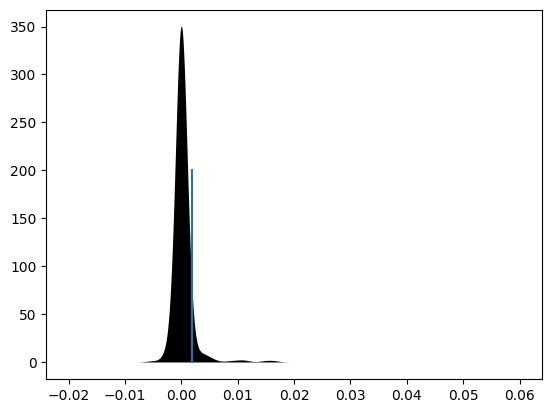

In [76]:
# Plot distribution of connectivity strength
if source_neurons == 'RRN_BPN':

    source = 'source_1' # 'source_1', 'source_2'

    data_to_plot = df_targets_ranked['conn_strength_'+source].to_numpy()
    binwidth = 0.001
    percentile = 95
    
    # Histogram
    #plt.hist(data_to_plot, bins=np.arange(-0.02-binwidth/2, 0.06+binwidth/2+binwidth, binwidth), weights=np.ones_like(data_to_plot) / len(data_to_plot)) #, density=True)
    
    # Kernel density estimate
    x = np.linspace(-0.02, 0.06, 1000)
    x = x.reshape(-1, 1)
    data_to_plot = data_to_plot.reshape(-1,1)
    kde = KernelDensity(kernel="gaussian", bandwidth=0.001).fit(data_to_plot)
    log_dens = kde.score_samples(x)
    
    fig, ax = plt.subplots()
    ax.fill(x[:, 0], np.exp(log_dens), fc="#000000")
    
    # Add percentile
    pctl = np.percentile(data_to_plot, percentile)
    ax.plot([pctl,pctl],[0,200])
    
    #plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
    plt.show()

BDN2 walking initiation, speed
DNb08 walking initiation
BDN2 walking initiation, speed
MDN walking backward
DNg13 walking turning
MDN walking backward
DNb08 walking initiation
DNb08 walking initiation
DNb08 walking initiation
MDN walking backward
oDN1 walking initiation
DNg13 walking turning
oDN1 walking initiation
MDN walking backward
DNa01 walking turning
DNa01 walking turning
DNa03 walking, flight turning
DNa03 walking, flight turning
DNb01 flight turning
DNb01 flight turning
DNa02 walking turning
DNa02 walking turning
DNb05 walking turning
Bluebell walking stopping
Bluebell walking stopping
DNp09 walking turning
DNp09 walking turning
DNa11 walking, flight turning
DNg02 flight speed
DNg02 flight speed
DNa11 walking, flight turning


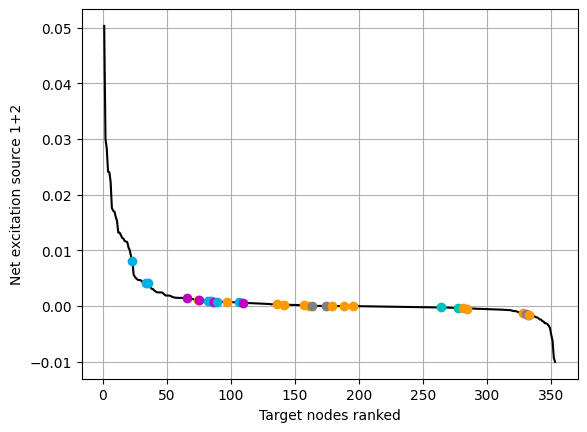

In [77]:
# Plot combined net excitation onto target nodes 
if source_neurons == 'RRN_BPN':
    plt.plot(df_targets_ranked.rank_source_12, df_targets_ranked.conn_strength_source_12, color='k')
    
    target_ids = df_targets_ranked.root_id.tolist()
    ids_of_interest = df_neurons_of_interest.connectome_id.tolist()
    for index, target_id in enumerate(target_ids):
        color = [0,0,0]
        if target_id in ids_of_interest:
            name = df_neurons_of_interest.community_name[df_neurons_of_interest.connectome_id == target_id].item()       
            motor_program = df_neurons_of_interest.motor_program[df_neurons_of_interest.connectome_id == target_id].item()
            motor_function = df_neurons_of_interest.motor_function[df_neurons_of_interest.connectome_id == target_id].item()
            if not pd.isnull(motor_function):
                print(name + ' ' + motor_program + ' ' + motor_function)
                if ('walking' in motor_program) & ('initiation' in motor_function):
                    color = [0,173/255,228/255]
                elif ('walking' in motor_program) & ('turning' in motor_function):
                    color = [1,153/255,0]    
                elif ('walking' in motor_program) & ('stopping' in motor_function):
                    color = [0,191/255,191/255]
                elif ('walking' in motor_program) & ('backward' in motor_function):
                    color = color = [191/255,0,191/255]
                elif 'flight' in motor_program:
                    color = [.5,.5,.5]
                else:
                    color = [1,0,0]
                plt.plot(index+1, df_targets_ranked.conn_strength_source_12[df_targets_ranked.root_id == target_id], 'o', color=color)
        
    plt.grid()
    plt.xlabel('Target nodes ranked')
    plt.ylabel('Net excitation source 1+2')
    # plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
    plt.show()

In [83]:
# Find target neurons on specific axes
if source_neurons == 'RRN_BPN':
    # RR axis
    df_temp = df_targets_ranked.sort_values(by='conn_strength_source_1', ascending=False)
    df_temp = df_temp[(df_temp.conn_strength_source_1>0.002) & (df_temp.conn_strength_source_2<0.005)]
    
    # BPN axis
    #df_temp = df_targets_ranked.sort_values(by='conn_strength_source_2', ascending=False)
    #df_temp = df_temp[(df_temp.conn_strength_source_2>0.01) & (df_temp.conn_strength_source_1<0.001)]
    
    # RR-BPN axis
    #df_temp = df_targets_ranked
    #df_temp = df_temp[(df_temp.conn_strength_source_1>0.001) & (df_temp.conn_strength_source_2>0.005)]
    
    df_temp

In [ ]:
## Find top n target neurons of a source
# n = 10
#df_temp = df_targets_ranked.sort_values(by='conn_strength_source_1', ascending=False)
#df_temp = df_temp[df_temp.rank_source_1 <= n]
#df_temp